# Practical exercise 3

*authors: Asan Agibetov, Georg Dorffner*

Our final practical exercise will feature a medical application, in particular, you will leverage the knowledge you have acquired in the previous exercises to build a CNN to classify MR (magnetic resonance) images of hearts. Towards the end of this exercise you will compare your model with a classifier based on the "Transfer Learning" technique, i.e., we will use a CNN pre-trained on big amounts of natural images and finetune it to our medical images.

Transfer learning is a very successful technique, we encourage you to read more about it in [these notes (Stanford course on CNNs)](http://cs231n.github.io/transfer-learning/).

> In practice, very few people train an entire Convolutional Network from   scratch (with random initialization), because it is relatively rare to    have a dataset of sufficient size. Instead, it is common to pretrain a    ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2        million images with 1000 categories), and then use the ConvNet either as  an initialization or a fixed feature extractor for the task of interest

**As in the handwritten digit recognition exercise**

**Due to the size and computational resource limitation imposed by Microsfot Azure Cloud platform for the free accounts, we will only use a fraction of available images both during training and testing. If you are preparing these exercises on your local machine, and have enough computational resources (any modern i5/i7 Intel CPU (or equivalent) machine), you could (and maybe you should) use the full dataset (contact your instructors to get the instructions for the full dataset).**

**Also, due to limited size of training samples transfer learning will most probably not perform better than a plain CNN trained from scratch, however, this exercise will give you the necessary experience to apply *transfer learning* to full datasets**

## Package imports and global settings

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torchvision import models
from torch.autograd import Variable
import matplotlib.pyplot as plt
import math
import random
import itertools as it

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/asan/.Virtualenvs/dl-no-cuda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Hyper parameters

In [3]:
# Hyper parameters
num_epochs = 10
batch_size = 10
learning_rate = 0.001

## Data preparation

In this exercise we provide data loaders for both training and testing phases. These data loaders prepare mini-batches of heart images, publicly available at the [Sunnybrook Cardiac Atlas project website](http://www.cardiacatlas.org/studies/sunnybrook-cardiac-data/). These images were used in the 2009 Cardiac MR Left Ventricle Segmentation Challenge held by the MICCAI (major conference in medical imaging) workshop 2009. As part of our exercise you will use these data to build an image classifier for four categories: healthy, hypertrophy, heart failure with infarction and heart failure without infarction.

In [4]:
train_dset = torch.load("./data/train.limited.pt")
test_dset = torch.load("./data/test.limited.pt")

As in the previous exercise, make sure that the data subsampling produces *balanced* classes (roughly equal number of samples for all categories).

In [5]:
from collections import Counter

tr_labels = [y for x, y in train_dset]
te_labels = [y for x, y in test_dset]
print(Counter(tr_labels))
print(Counter(te_labels))

Counter({0: 44, 2: 43, 3: 39, 1: 24})
Counter({0: 23, 2: 18, 3: 11, 1: 8})


**Note that each image is represented as three matrices with dimensions** $224 \times 224$. Although all of our images are *grayscale*, we need to keep the data in this format (three channels of pixel intensities) to use the pretrained network.

torch.Size([3, 224, 224])


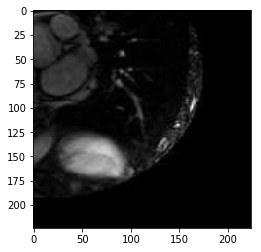

In [6]:
img, label = train_dset[0]
print(img.shape)
plt.set_cmap(plt.get_cmap("gray"))
plt.imshow(img[0].numpy(), interpolation="nearest")

torch.Size([3, 224, 224])


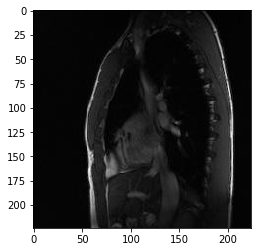

In [7]:
img, label = test_dset[0]
print(img.shape)
plt.set_cmap(plt.get_cmap("gray"))
plt.imshow(img[0].numpy(), interpolation="nearest")

In [8]:
# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dset,
                                          batch_size=batch_size,
                                          shuffle=False)

### Exercise 3.1 CNN from scratch

Use your knowledge to build CNNs and adapt them to our medical images. In particular you have to pay attention to the following:

* as opposed to 1-channel images of digits, we have 3-channel images here. Your convolutional layer will have to account to that!
* digit images had $28 \times 28$ dimensions, the images of hearts have the dimensions of $224 \times 224$.

Below we provide a *direct* adaptation of a 2-layer CNN to our medical dataset. Compare it to the model trained with "transfer learning" (plot loss error, report time it takes to train, and the mean accuracy score). Try to train *deeper* convolutional networks with more layers, by gradually convolving and downsampling the original and produced (filter) images, and compare these architectures to the pretrained model. 

In [9]:
# CNN Model (2 conv layer)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            # nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.Conv2d(3, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            # nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.Conv2d(16, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        # self.fc = nn.Linear(7*7*32, 10) 
        self.fc = nn.Linear(53*53*32, 10)
    
    def forward(self, x): 
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) 
        out = self.fc(out)
        return out 
    
cnn = CNN()

In [10]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

# Train the Model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images)
        labels = Variable(labels)

        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i+1) % 5 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f'
                   %(epoch+1, num_epochs, i+1, len(train_dset)//batch_size, loss.data[0]))

Epoch [1/10], Iter [5/15] Loss: 8.7041
Epoch [1/10], Iter [10/15] Loss: 8.3916
Epoch [1/10], Iter [15/15] Loss: 5.1696
Epoch [2/10], Iter [5/15] Loss: 5.5968
Epoch [2/10], Iter [10/15] Loss: 2.3308
Epoch [2/10], Iter [15/15] Loss: 4.1527
Epoch [3/10], Iter [5/15] Loss: 3.7836
Epoch [3/10], Iter [10/15] Loss: 4.8297
Epoch [3/10], Iter [15/15] Loss: 4.9489
Epoch [4/10], Iter [5/15] Loss: 0.8004
Epoch [4/10], Iter [10/15] Loss: 2.4890
Epoch [4/10], Iter [15/15] Loss: 2.0511
Epoch [5/10], Iter [5/15] Loss: 1.2745
Epoch [5/10], Iter [10/15] Loss: 1.5680
Epoch [5/10], Iter [15/15] Loss: 0.4877
Epoch [6/10], Iter [5/15] Loss: 0.8831
Epoch [6/10], Iter [10/15] Loss: 0.1279
Epoch [6/10], Iter [15/15] Loss: 0.0819
Epoch [7/10], Iter [5/15] Loss: 0.0084
Epoch [7/10], Iter [10/15] Loss: 0.6595
Epoch [7/10], Iter [15/15] Loss: 0.4897
Epoch [8/10], Iter [5/15] Loss: 0.0119
Epoch [8/10], Iter [10/15] Loss: 0.5612
Epoch [8/10], Iter [15/15] Loss: 0.0350
Epoch [9/10], Iter [5/15] Loss: 0.0116
Epoch [9/

In [11]:
# Test the Model
cnn.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images)
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Test Accuracy of the model on the %d test images: %d %%' % (len(test_dset), 100 * correct / total))

Test Accuracy of the model on the 60 test images: 40 %


## Transfer learning

Finally, we are going to use some transfer learning. `pytorch` conveniently provides pre-trained networks in its *model zoo*. Here we will use the [ResNet-18](https://arxiv.org/abs/1512.03385) model trained on [ImageNet](www.image-net.org) dataset (over ten million of annotated images available on the Web). As you will see, the ResNet-18 model allows efficient training of very *deep* Convolutional Neural Networks (original paper mentions up to 152 layers, we will *only* use 18 layers).

In the following we *fine-tune* the ResNet-18 to our problem, i.e., we load a pretrained model and reset the final fully connected layer (classification pipeline). Original ResNet-18 used a fully connected layer to classify images belonging to thousands of categories, in our case we only have 4 categories. The rest of training proceeds as usual.

In [12]:
RESNET18 = models.resnet18(pretrained=True)
RESNET18.fc = nn.Linear(RESNET18.fc.in_features, 4)

In [13]:
RESNET18

ResNet(
  (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNo

In [14]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(RESNET18.parameters(), lr=learning_rate)

# Train the Model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images)
        labels = Variable(labels)

        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = RESNET18(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i+1) % 5 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f'
                   %(epoch+1, num_epochs, i+1, len(train_dset)//batch_size, loss.data[0]))

Epoch [1/10], Iter [5/15] Loss: 2.3136
Epoch [1/10], Iter [10/15] Loss: 1.7428
Epoch [1/10], Iter [15/15] Loss: 1.7186
Epoch [2/10], Iter [5/15] Loss: 1.0265
Epoch [2/10], Iter [10/15] Loss: 1.2812
Epoch [2/10], Iter [15/15] Loss: 1.2614
Epoch [3/10], Iter [5/15] Loss: 1.0787
Epoch [3/10], Iter [10/15] Loss: 1.1311
Epoch [3/10], Iter [15/15] Loss: 1.4481
Epoch [4/10], Iter [5/15] Loss: 0.9349
Epoch [4/10], Iter [10/15] Loss: 2.2160
Epoch [4/10], Iter [15/15] Loss: 1.3324
Epoch [5/10], Iter [5/15] Loss: 1.5090
Epoch [5/10], Iter [10/15] Loss: 1.0662
Epoch [5/10], Iter [15/15] Loss: 0.7939
Epoch [6/10], Iter [5/15] Loss: 0.7781
Epoch [6/10], Iter [10/15] Loss: 0.7934
Epoch [6/10], Iter [15/15] Loss: 0.8270
Epoch [7/10], Iter [5/15] Loss: 0.8203
Epoch [7/10], Iter [10/15] Loss: 1.3532
Epoch [7/10], Iter [15/15] Loss: 0.8904
Epoch [8/10], Iter [5/15] Loss: 0.6782
Epoch [8/10], Iter [10/15] Loss: 0.7326
Epoch [8/10], Iter [15/15] Loss: 0.2058
Epoch [9/10], Iter [5/15] Loss: 0.1817
Epoch [9/

In [15]:
# Test the Model
RESNET18.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images)
    outputs = RESNET18(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Test Accuracy of the model on the %d test images: %d %%' % (len(test_dset), 100 * correct / total))

Test Accuracy of the model on the 60 test images: 36 %
